In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
#pip install sqlalchemy pandas (creates database)
from sqlalchemy import create_engine
import sqlite3
import seaborn as sns

In [40]:
#connect to database
conn = sqlite3.connect('supply.db')
df = pd.read_csv('supply_chain.csv')
df.to_csv('supply_chain_cleaned.csv', index=False)

In [41]:
# # Run SQL query
# df_vietnam = pd.read_sql('SELECT * FROM my_table WHERE Country = "Vietnam";', conn)
# df_vietnam.to_csv('supply_chain_cleaned.csv', index=False)

# conn.close()

In [42]:
#Obj 1

# Make a new column that shows the difference in days between the Scheduled Delivery Date and the Delivered to Client Date
df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'], format='%d-%b-%y', errors='coerce')

df['Delivered to Client Date'] = pd.to_datetime(df['Delivered to Client Date'], format='%d-%b-%y', errors='coerce')
df['Days Difference'] = (df['Delivered to Client Date'] - df['Scheduled Delivery Date']).dt.days

df.to_csv('supply_chain_cleaned.csv', index=False)

In [43]:
# we want to isolate all the rows where the time it took to deliver is not 0
#so this nested df format df[df['Days Difference'] != 0] will basically say that if the inside is true, keep else drop
df_delivery = df[df['Days Difference'] != 0]
df_delivery.to_csv('supply_chain_cleaned.csv', index=False)


# correlation of Days difference with Numerical data

Unit of Measure (Per Pack)    0.001774
Line Item Quantity           -0.029664
Line Item Value              -0.015638
Pack Price                    0.063008
Unit Price                    0.031130
Line Item Insurance (USD)    -0.001316
Days Difference               1.000000
Name: Days Difference, dtype: float64


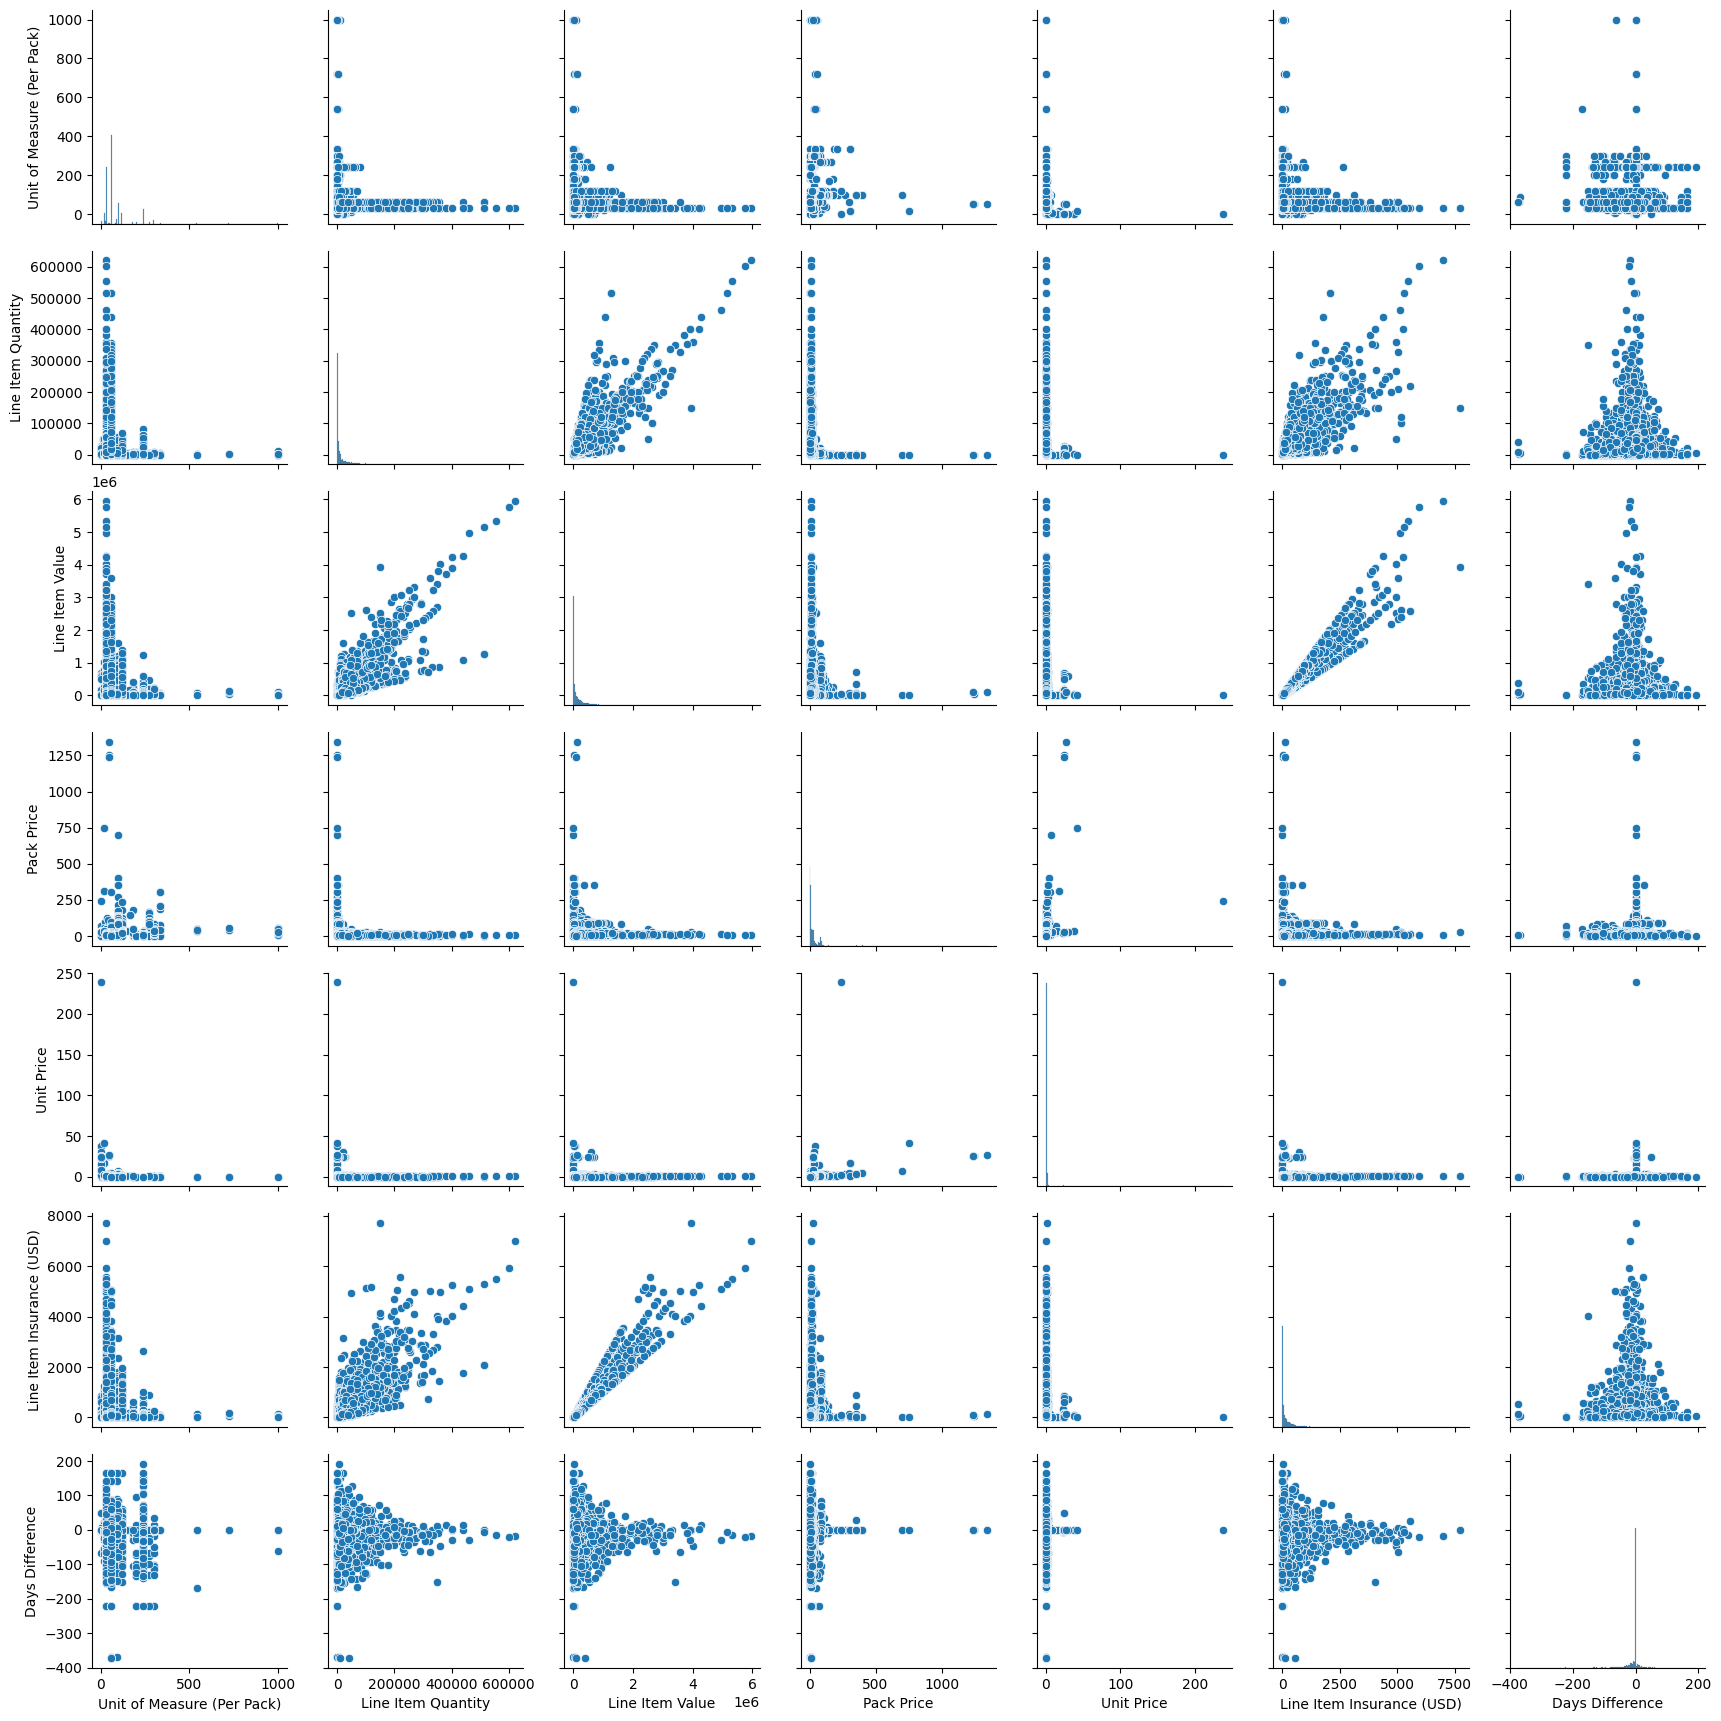

In [44]:
# we want to look for coorelations between the columns to see if there is any relationships that might indicate a pattern
corr_cols = df.columns.tolist()
numeric = df.select_dtypes(include='number').columns.tolist()

#remove irrelvent columns
numeric.remove('ID')

print(df[numeric].corr()['Days Difference'])

sns.pairplot(df[numeric])

# Now, we can examine the categorical data and if that has anything to do with the days difference

Text(0, 0.5, 'Average Days Difference')

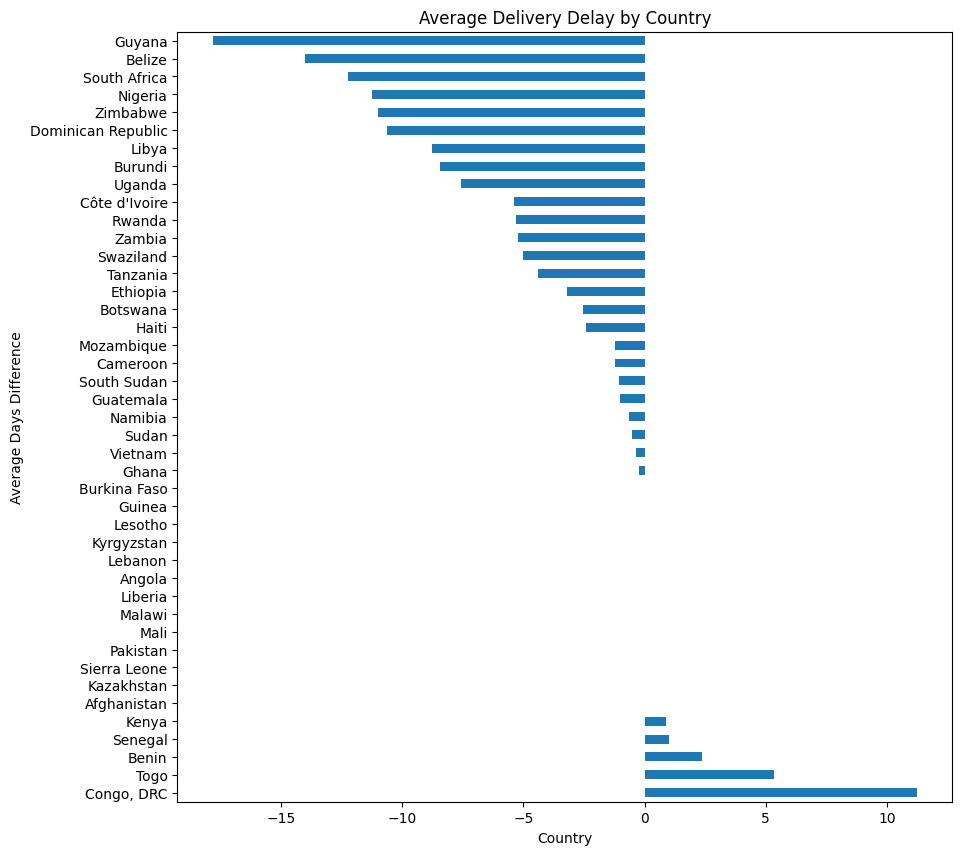

In [45]:
#create a Series that shows the mean of the Days Difference for each countr
delay = df.groupby('Country')['Days Difference'].mean().sort_values(ascending=[False])

delay.plot(kind ='barh', figsize=(10, 10), title='Average Delivery Delay by Country')
plt.xlabel('Country')
plt.ylabel('Average Days Difference')

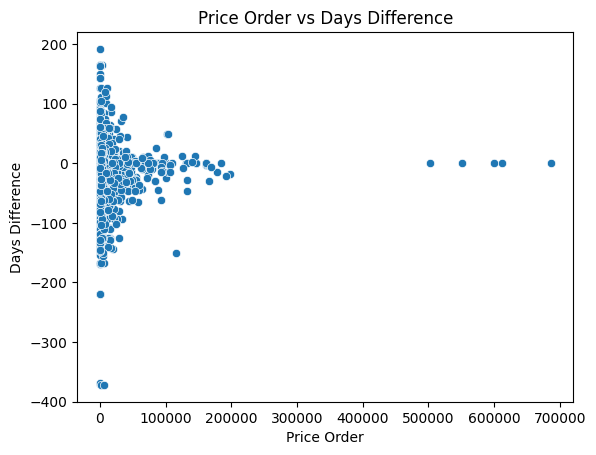

In [46]:
df['Price Order'] = df['Line Item Quantity'] * df['Unit Price']
df.to_csv('supply_chain_cleaned.csv', index=False)

#we want to see if there is a correlation between the price order and the days difference
sns.scatterplot(data=df, x='Price Order', y='Days Difference')
plt.title('Price Order vs Days Difference')
plt.xlabel('Price Order')
plt.ylabel('Days Difference')
plt.show()



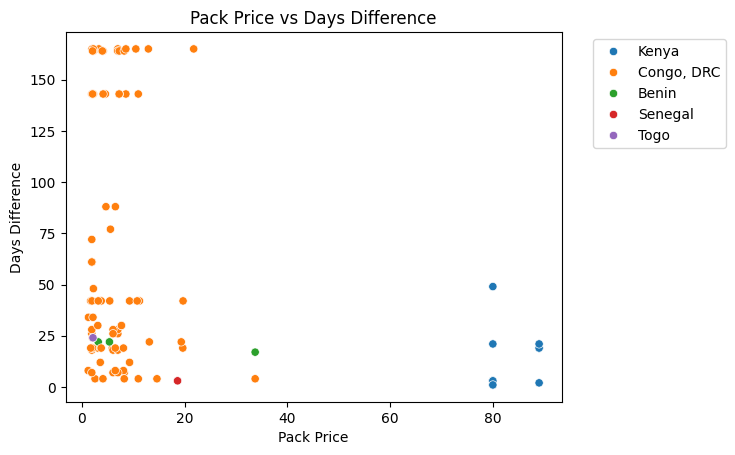

In [47]:
#select the top 5 counties with an average days difference greater than 0
delayed_countries = ['Congo, DRC', 'Togo', 'Benin', 'Senegal', 'Kenya']

filtered_data = df[
    (df['Days Difference'] > 0) &
    (df['Country'].isin(delayed_countries))
]

#plot and color code by country
sns.scatterplot(x='Pack Price', y='Days Difference', data=filtered_data, hue='Country',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Pack Price vs Days Difference')
plt.xlabel('Pack Price')
plt.ylabel('Days Difference')
plt.show()

In [48]:
#we want to see if the shipment mode (air vs truck) has anything to do with the days difference

#in gneral 
df.groupby('Shipment Mode')['Days Difference'].mean()

Shipment Mode
Air            -3.763782
Air Charter   -19.036923
Ocean           5.870620
Truck          -9.921908
Name: Days Difference, dtype: float64

In [49]:
#for the delayed countries
filtered_data = df[
    (df['Days Difference'] > 0) &
    (df['Country'].isin(delayed_countries))
]

filtered_data.groupby('Shipment Mode')['Days Difference'].mean()


Shipment Mode
Air    55.872549
Name: Days Difference, dtype: float64

So from the data, it is indicating that the countries with the most delays seem to be either landlocked or does not have the ability to ship via ocean or truck

In [50]:
#Does fulfillment mode have an impact on the days difference?

#general
df.groupby('Fulfill Via')['Days Difference'].mean()

Fulfill Via
Direct Drop   -3.540650
From RDC      -8.284049
Name: Days Difference, dtype: float64

In [51]:
filtered_data.groupby('Fulfill Via')['Days Difference'].mean()

Fulfill Via
Direct Drop    12.125000
From RDC       64.011628
Name: Days Difference, dtype: float64

In [52]:
#we want to see if product type has an impact on the days difference
df.groupby('Product Group')['Days Difference'].mean()


Product Group
ACT    -10.562500
ANTM    -2.772727
ARV     -7.244094
HRDT    -0.011574
MRDT     0.000000
Name: Days Difference, dtype: float64

In [53]:
#for the delayed countries
filtered_data.groupby('Product Group')['Days Difference'].mean()

Product Group
ARV     62.863636
HRDT    11.928571
Name: Days Difference, dtype: float64

In [54]:
# we want to see if the Vendor INCO terms have an impact on the days difference
df.groupby('Vendor INCO Term')['Days Difference'].mean()


Vendor INCO Term
CIF                0.000000
CIP               -0.949091
DAP                0.000000
DDP              -11.979210
DDU               -1.733333
EXW                0.018359
FCA                0.256927
N/A - From RDC    -8.284049
Name: Days Difference, dtype: float64

In [55]:
#Inco for the delayed countries
filtered_data.groupby('Vendor INCO Term')['Days Difference'].mean()

Vendor INCO Term
EXW               11.666667
FCA               19.000000
N/A - From RDC    64.011628
Name: Days Difference, dtype: float64

Time Series Analysis on the Days difference Data

In [56]:
df['Shipment Month'] = df['Scheduled Delivery Date'].dt.month
df.to_csv('supply_chain_cleaned.csv', index=False)

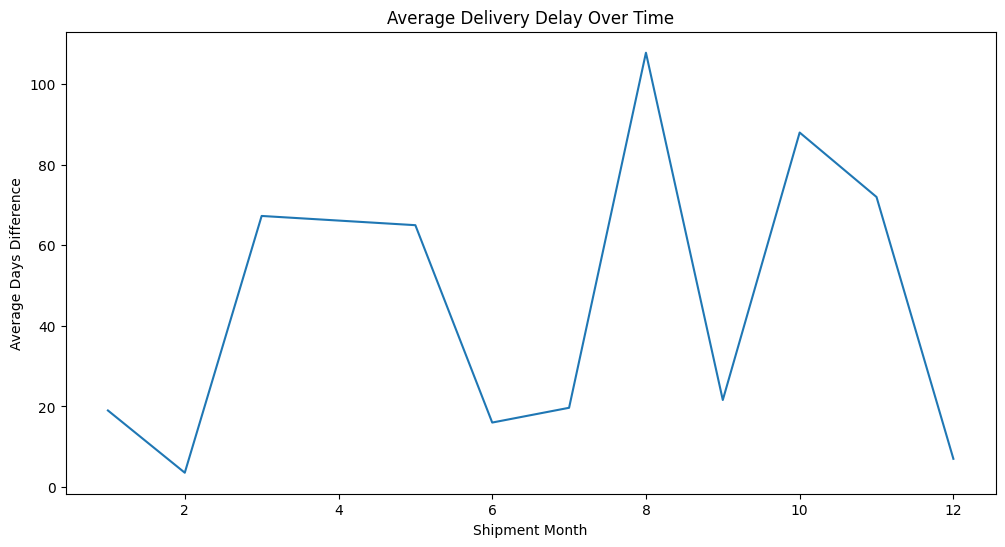

In [57]:
filtered_data = df[
    (df['Days Difference'] > 0) &
    (df['Country'].isin(delayed_countries))
]

filtered_data.groupby('Shipment Month')['Days Difference'].mean().plot(figsize=(12,6))
plt.ylabel('Average Days Difference')
plt.title('Average Delivery Delay Over Time')
plt.show()